In [1]:
import pandas as pd
import darts
import plotly.express as px

In [2]:
df = pd.read_csv('./raw_data/Electric_Production.csv', index_col=[0], parse_dates=[0])

In [3]:
df = df.sort_index()

In [4]:
df.index.is_monotonic_increasing

True

In [5]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [6]:
fig = px.line(df, x=df.index, y="IPG2211A2N")
fig.show()

c:\Users\wilte\OneDrive\Рабочий стол\projects\sochi-2023\venv\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
decomposed = seasonal_decompose(df)

In [9]:
px.line(decomposed.trend)

c:\Users\wilte\OneDrive\Рабочий стол\projects\sochi-2023\venv\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [10]:
px.line(decomposed.seasonal)

c:\Users\wilte\OneDrive\Рабочий стол\projects\sochi-2023\venv\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [11]:

px.line(decomposed.resid)

c:\Users\wilte\OneDrive\Рабочий стол\projects\sochi-2023\venv\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [12]:
from darts.models import  NBEATSModel
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries

In [13]:
df_t = TimeSeries.from_dataframe(df)
train, val = df_t.split_after(pd.Timestamp('2013'))

In [57]:
df_t.n_components

1

In [50]:
df_t

<TimeSeries (DataArray) (DATE: 397, component: 1, sample: 1)>
array([[[ 72.5052]],

       [[ 70.672 ]],

       [[ 62.4502]],

       [[ 57.4714]],

       [[ 55.3151]],

       [[ 58.0904]],

       [[ 62.6202]],

       [[ 63.2485]],

       [[ 60.5846]],

       [[ 56.3154]],

...

       [[ 88.353 ]],

       [[ 92.0805]],

       [[102.1532]],

       [[112.1538]],

       [[108.9312]],

       [[ 98.6154]],

       [[ 93.6137]],

       [[ 97.3359]],

       [[114.7212]],

       [[129.4048]]])
Coordinates:
  * DATE       (DATE) datetime64[ns] 1985-01-01 1985-02-01 ... 2018-01-01
  * component  (component) object 'IPG2211A2N'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [14]:
from darts.models import DLinearModel

In [20]:
from darts.datasets import WeatherDataset
series = WeatherDataset().load()

In [55]:
series.width

21

In [62]:
target = df_t[:300]


In [63]:
model = DLinearModel(

    input_chunk_length=6,

    output_chunk_length=6,

    n_epochs=20,

)

model.fit(target)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 42    
5 | linear_trend    | Linear           | 42    
-----------------------------------------------------
84        Trainable params
0         Non-trainable params
84        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


DLinearModel(shared_weights=False, kernel_size=25, const_init=True, use_static_covariates=True, input_chunk_length=6, output_chunk_length=6, n_epochs=20)

In [64]:
pred = model.predict(6)

pred.values()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

array([[107.21438403],
       [104.0912897 ],
       [ 96.89774675],
       [ 94.04458376],
       [ 97.26298452],
       [104.21360169]])

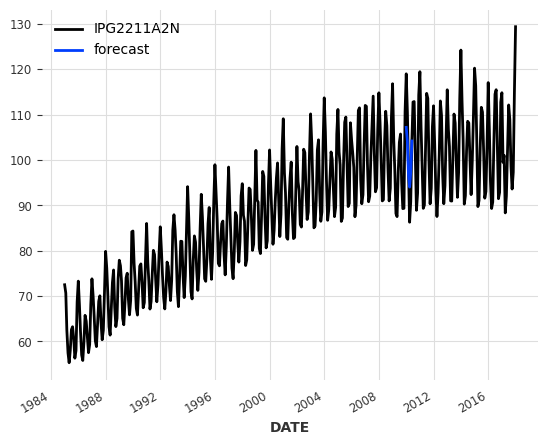

In [72]:
import matplotlib.pyplot as plt

df_t.plot()
pred.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

<Axes: xlabel='DATE'>

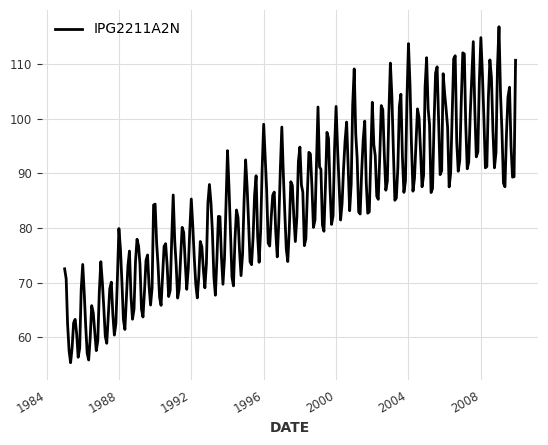

In [71]:
target.plot()

<Axes: xlabel='DATE'>

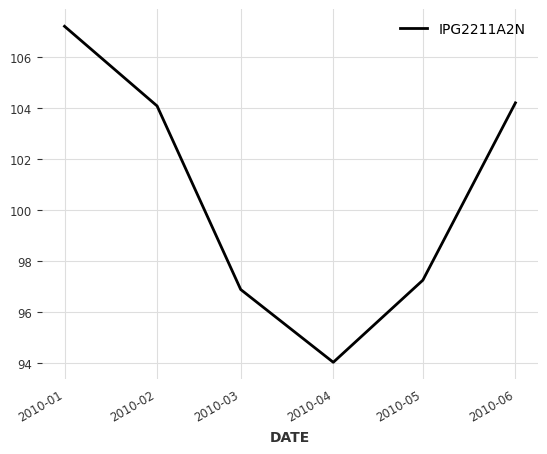

In [68]:
pred.plot()

In [65]:
df_t[100:106]

<TimeSeries (DataArray) (DATE: 6, component: 1, sample: 1)>
array([[[67.6762]],

       [[74.3297]],

       [[82.1048]],

       [[82.0605]],

       [[74.6031]],

       [[69.681 ]]])
Coordinates:
  * DATE       (DATE) datetime64[ns] 1993-05-01 1993-06-01 ... 1993-10-01
  * component  (component) object 'IPG2211A2N'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [31]:
NBEATS_MODEL = NBEATSModel(input_chunk_length = 30, output_chunk_length =7 , n_epochs=100, random_state=42)
#give the .fit method the training series and the validation series
NBEATS_MODEL.fit(train, val_series = val, verbose=True)
#get the predictions for the next TESTING DATA, 6 MONTH = 360 DAYS 
pred_closing = NBEATS_MODEL.predict(n=360, series = train)
#get the error using the mape
pred_error = mape(val[:360],pred_closing)
#error_follower = mape(val_follower[:36],pred_follower)
print("this is the error for the closing price:",pred_error )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
24.972    Total estimated model params size (MB)


c:\Users\wilte\OneDrive\Рабочий стол\projects\sochi-2023\venv\Lib\site-packages\torch\__init__.py:614: UserWarning:

torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)



Epoch 99: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s, train_loss=6.230, val_loss=23.80]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s, train_loss=6.230, val_loss=23.80]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
this is the error for the closing price: 3.3215403331824622


In [34]:
from darts.utils.statistics import plot_acf, check_seasonality

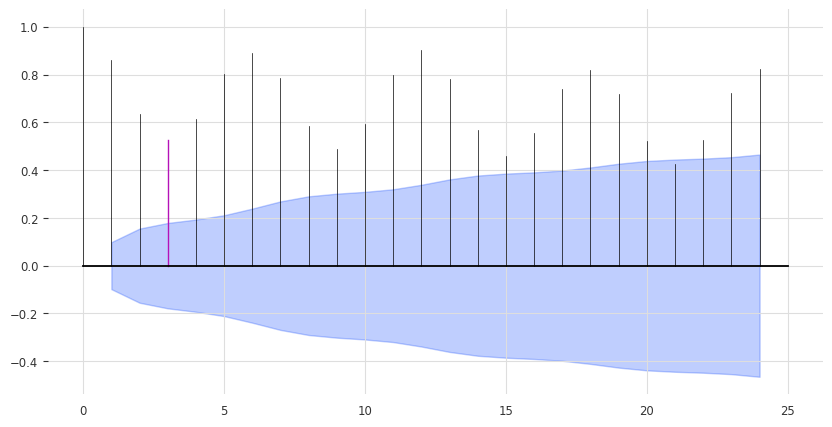

In [54]:
plot_acf(df_t, m=3, alpha=0.05)

In [55]:
from darts.models import NLinearModel

In [61]:
target = series['p (mbar)'][:100]

# optionally, use past observed rainfall (pretending to be unknown beyond index 100)

past_cov = series['rain (mm)'][:100]

# optionally, use future temperatures (pretending this component is a forecast)

future_cov = series['T (degC)'][:106]

In [67]:
model = NLinearModel(

    input_chunk_length=6,

    output_chunk_length=6,

    n_epochs=200,

)

model.fit(target, past_covariates=past_cov, future_covariates=future_cov)

pred = model.predict(6)

pred.values()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type             | Params
----------------------------------------------------
0 | criterion      | MSELoss          | 0     
1 | train_metrics  | MetricCollection | 0     
2 | val_metrics    | MetricCollection | 0     
3 | layer          | Linear           | 114   
4 | linear_fut_cov | Linear           | 2     
----------------------------------------------------
116       Trainable params
0         Non-trainable params
116       Total params
0.000     Total estimated model params size (MB)


Epoch 0:  33%|███▎      | 1/3 [00:00<00:00, 90.91it/s, train_loss=4.52e+5]

Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 99.93it/s, train_loss=4.110]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 96.77it/s, train_loss=4.110]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.30it/s]


array([[1007.19746455],
       [1006.65595569],
       [1006.16863292],
       [1005.77119675],
       [1005.50859742],
       [1005.42290298]])

In [56]:
from darts.datasets import WeatherDataset

from darts.models import NLinearModel

series = WeatherDataset().load()

In [70]:
from darts.models import DLinearModel

In [76]:
model = DLinearModel(

    input_chunk_length=6,

    output_chunk_length=6,

    n_epochs=20,

)

model.fit(target, past_covariates=past_cov, future_covariates=future_cov)

pred = model.predict(6)

pred.values()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 114   
5 | linear_trend    | Linear           | 114   
6 | linear_fut_cov  | Linear           | 2     
-----------------------------------------------------
230       Trainable params
0         Non-trainable params
230       Total params
0.001     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s] 

Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 88.44it/s, train_loss=1.19e+5] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 88.44it/s, train_loss=1.19e+5]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.76it/s]


array([[668.5655716 ],
       [668.39666029],
       [667.46341501],
       [667.11458211],
       [666.85908183],
       [667.02046294]])